# **Curvetopia**

Objective: Our mission is to identify, regularize, and beautify curves in 2D Euclidean space. <br/>We'll start by focusing on closed curves and progressively work with more complex shapes. <br/>This project will also cover symmetry and curve completion techniques.<br/><br/>
Problem description: Ideally we want an end to end process <br/>where we take a PNG
(raster) image of a line art and output a set of curves, <br/>where the curves are defined as a connected sequence of cubic Bezier curves.

## **Required Python Libraries**

### **Installation**



In [60]:
!pip install svgwrite cairosvg scipy

# Clear root directory
!rm -rf /content/*

# Extract the file from the Drive link
!pip install gdown
!gdown --id 1KqgajSmV3WRRQjY6Z0F1fkUpxX12SSjE -O problems.zip

# Unzip the downloaded file
!unzip problems.zip -d new_problems

# Remove the zip file
!rm problems.zip

# Simplify dataset access
!rm -r /content/new_problems/problems/__MACOSX
!mv -f /content/new_problems/problems/* /content/
!rm -rf /content/new_problems

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KqgajSmV3WRRQjY6Z0F1fkUpxX12SSjE
To: /content/problems.zip
100% 696k/696k [00:00<00:00, 69.2MB/s]
Archive:  problems.zip
   creating: new_problems/problems/
   creating: new_problems/problems/problems/
  inflating: new_problems/problems/problems/.DS_Store  
  inflating: new_problems/problems/problems/frag0.csv  
  inflating: new_problems/problems/problems/frag0.svg  
  inflating: new_problems/problems/problems/frag01_sol.csv  
  inflating: new_problems/problems/problems/frag01_sol.svg  
  inflating: new_problems/problems/problems/frag1.csv  
  inflating: new_problems/problems/problems/frag1.svg  
  inflating: new_problems/problems/problems/frag2.csv  
  inflating: new_problems/problems/problems/frag2.svg  
  inflatin

### **Importing Modules into Python3**

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import svgwrite
import cairosvg
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull
from PIL import Image
import io
import cv2
from google.colab.patches import cv2_imshow
import imutils
from scipy.spatial.transform import Rotation as R
from math import sqrt
from copy import copy
from scipy.interpolate import interp1d

## **Global Variables**

In [62]:
# Colours list
colours = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#33FFA1', '#FFBF00']

# Use case
use_case = "occlusion1"

# Input file path
input_csv_path = f"/content/problems/{use_case}.csv"

# Input JPG file
input_jpg_path = f"/content/{use_case}.jpg"

# Smoothened image path
smoothened_jpg_path = f"/content/{use_case}_smooth.jpg"

# JPG Test file
regularized_jpg_path = f"/content/{use_case}_sol.jpg"

# Output JPG file
output_jpg_path = f"/content/{use_case}_sol1.jpg"

# Input SVG file
output_svg_path = f"/content/{use_case}.svg"

# Square root of 2 (for trigonometry)
two_root = sqrt(2)

## **Read CSV File**
Using code provided by Adobe Experts

In [63]:
def pretty_print_paths(paths_XYs):
    """
    Prints the content of the paths_XYs array in a human-readable format.

    :param paths_XYs: List of lists of NumPy arrays containing XY coordinates.
    """
    for i, path in enumerate(paths_XYs):
        print(f"Path {i + 1}:")

        for j, XY in enumerate(path):
            print(f"  Segment {j + 1}:")

            for point in XY:
                print(f"    ({point[0]}, {point[1]})")

        print("")  # Blank line between paths for clarity
output_csv_path = f"/content/problems/{use_case}_sol.csv"
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    # Calculate the global maximum y value
    global_max_y = np.max(np_path_XYs[:, 2])

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            # Invert the y-coordinate relative to the global maximum y
            XY[:, 1] = global_max_y - XY[:, 1]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

path_YXs = read_csv(output_csv_path)

# Function call
path_XYs = read_csv(input_csv_path)

## **Visualize Polylines**
Using code provided by Adobe Experts

Image saved as /content/occlusion1.jpg


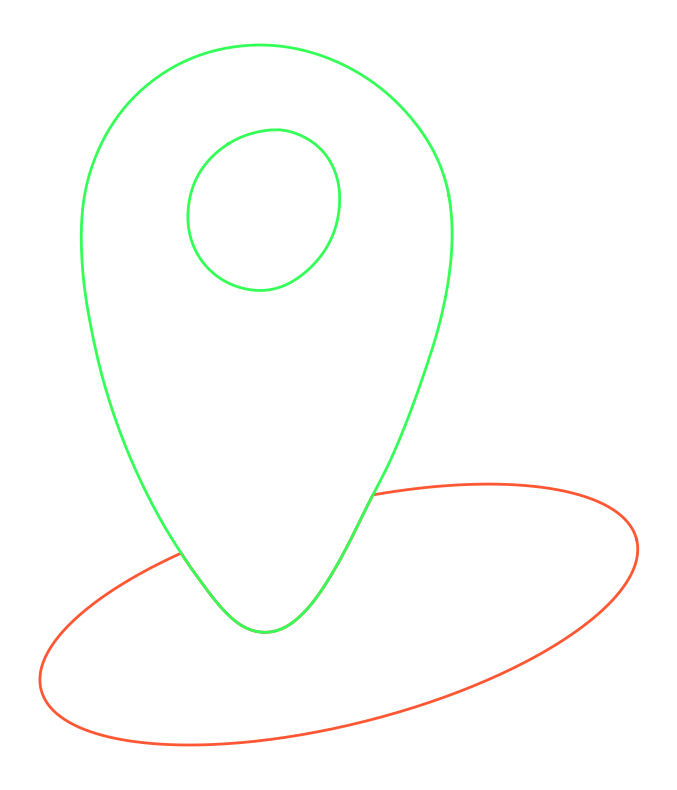

In [64]:
def plot(path_XYs, jpg_path):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    # Set the aspect ratio to be equal and turn off the axes
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    # Save the figure directly to a JPG file without axes
    # plt.show()
    plt.savefig(jpg_path, format='jpeg', bbox_inches='tight', pad_inches=0, dpi=100)
    print(f"Image saved as {jpg_path}")

# Function call
plot(path_XYs, input_jpg_path)

### **Evaluate Output as SVG**

In [65]:
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0

    # Calculate the maximum width and height
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))

    # Add padding
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()

    # Add paths to the SVG
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]

        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))

            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))

            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))

        group.add(
            dwg.path(
                d=path_data,
                fill=c,
                stroke='none',
                stroke_width=2
            )
        )

    dwg.add(group)
    dwg.save()

    # Convert SVG to PNG
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))

    cairosvg.svg2png(
        url=svg_path,
        write_to=png_path,
        parent_width=W,
        parent_height=H,
        output_width=fact * W,
        output_height=fact * H,
        background_color='white'
    )

    return png_path

# Function call
polylines2svg(path_XYs, output_svg_path)

'/content/occlusion1.png'

## **Smoothening Irregular Curves Using Bézier Curves**

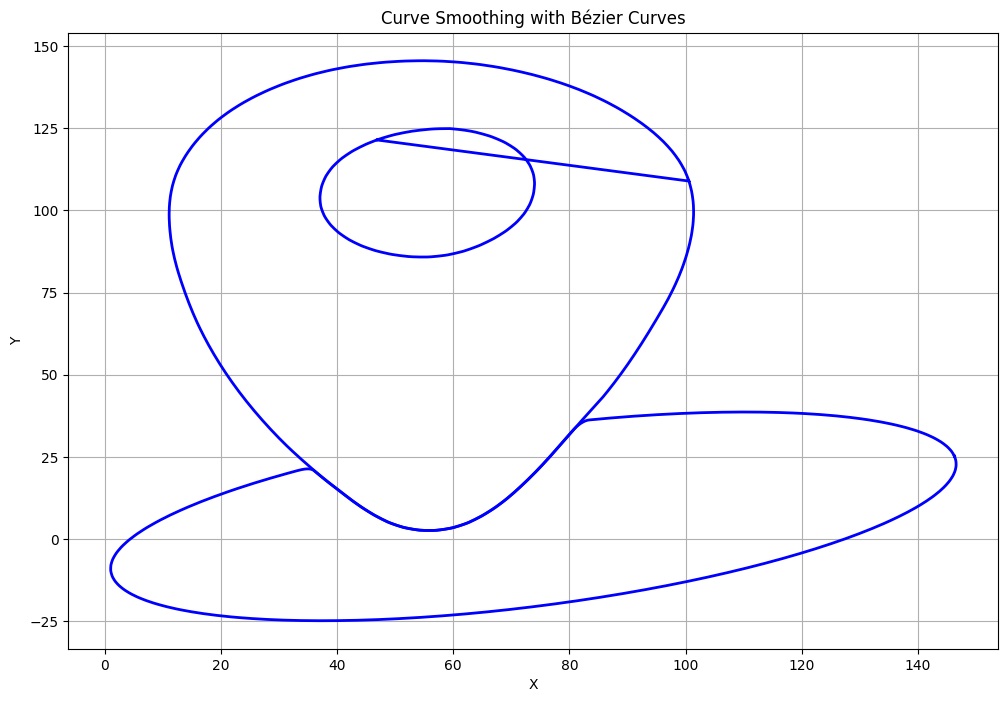

In [66]:
def bezier_curve(P0, P1, P2, P3, num_points=100):
    """
    Generate a cubic Bézier curve from control points.

    :param P0, P1, P2, P3: Control points for the Bézier curve.
    :param num_points: Number of points to generate along the curve.
    :return: Array of points along the Bézier curve.
    """
    t = np.linspace(0, 1, num_points).reshape(-1, 1)  # Reshape `t` to be a column vector
    curve = ((1-t)**3 * P0) + (3*(1-t)**2 * t * P1) + (3*(1-t) * t**2 * P2) + (t**3 * P3)
    return curve

def fit_bezier_segments(path_XYs, segment_length=4):
    """
    Fit cubic Bézier curves to segments of path_XYs.

    :param path_XYs: List of lists of NumPy arrays containing XY coordinates.
    :param segment_length: Number of points in each segment.
    :return: Smoothened curves as a list of lists of NumPy arrays.
    """
    smooth_paths = []

    for path in path_XYs:
        bezier_curves = []

        for XY in path:
            num_points = len(XY)

            # Loop through points in segments
            for i in range(0, num_points - segment_length + 1, segment_length - 1):
                # Select the points for the current segment
                segment = XY[i:i + segment_length]

                # Ensure there are enough points
                if len(segment) < segment_length:
                    break

                # Select control points
                P0, P1, P2, P3 = segment[0], segment[1], segment[2], segment[3]

                # Fit a Bézier curve to the segment
                curve = bezier_curve(P0, P1, P2, P3)
                bezier_curves.append(curve)

        # Concatenate the Bézier curve segments for the current path
        smooth_path = np.concatenate(bezier_curves, axis=0)
        smooth_paths.append(smooth_path)

    return smooth_paths

def plot_paths(smoothened_paths):
    """
    Plot the original and smoothened paths.

    :param original_paths: Original path_XYs containing the paths.
    :param smooth_paths: Smoothened paths as a list of lists of NumPy arrays.
    """
    plt.figure(figsize=(12, 8))

    for smooth in smoothened_paths:
        plt.plot(smooth[:, 0], smooth[:, 1], 'b-', linewidth=2)

    plt.title('Curve Smoothing with Bézier Curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# Smooth the curves
smoothened_paths = fit_bezier_segments(path_XYs, segment_length=4)

# Plot the results
plot_paths(smoothened_paths)

### **Saving Curves as JPG**

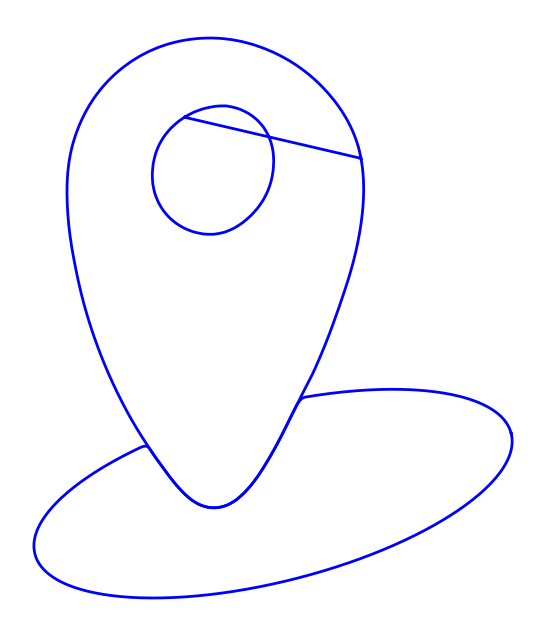

In [67]:
def plot_paths_on_canvas(smoothened_paths, jpg_filename, canvas_size=(800, 800), line_width=2):
    """
    Plot the smoothened paths on a white canvas and save them as a JPG file.

    :param smoothened_paths: Smoothened paths as a list of NumPy arrays.
    :param jpg_filename: Name of the JPG file to save.
    :param canvas_size: Size of the canvas (width, height).
    :param line_width: Width of the lines drawn.
    """
    # Create a new figure with a white background
    fig, ax = plt.subplots(figsize=(canvas_size[0] / 100, canvas_size[1] / 100), dpi=100)
    ax.set_facecolor('white')

    # Plot each smoothened path
    for smooth in smoothened_paths:
        plt.plot(smooth[:, 0], smooth[:, 1], 'b-', linewidth=line_width)

    # Set the aspect ratio to be equal and turn off the axes
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    # Save the figure directly to a JPG file
    plt.savefig(jpg_filename, format='jpeg', bbox_inches='tight', pad_inches=0, dpi=100)

# Save the smoothened paths as a JPG directly
jpg_data = plot_paths_on_canvas(smoothened_paths, smoothened_jpg_path)

## **Problem 3**
### **Completing Incomplete Curves**
Imagine a scenario where a set of 2D curves has been "planarized," meaning that any overlapping sections have been removed, leaving gaps or partial holes. <br/>Your task is to develop algorithms that can identify these incomplete curves and fill in the missing parts in a natural and seamless way. <br/>The goal is to restore the curves to their original form, accounting for different levels of occlusion, from fully contained curves to those that are partially or entirely disconnected.

Image saved as /content/occlusion1_sol1.jpg


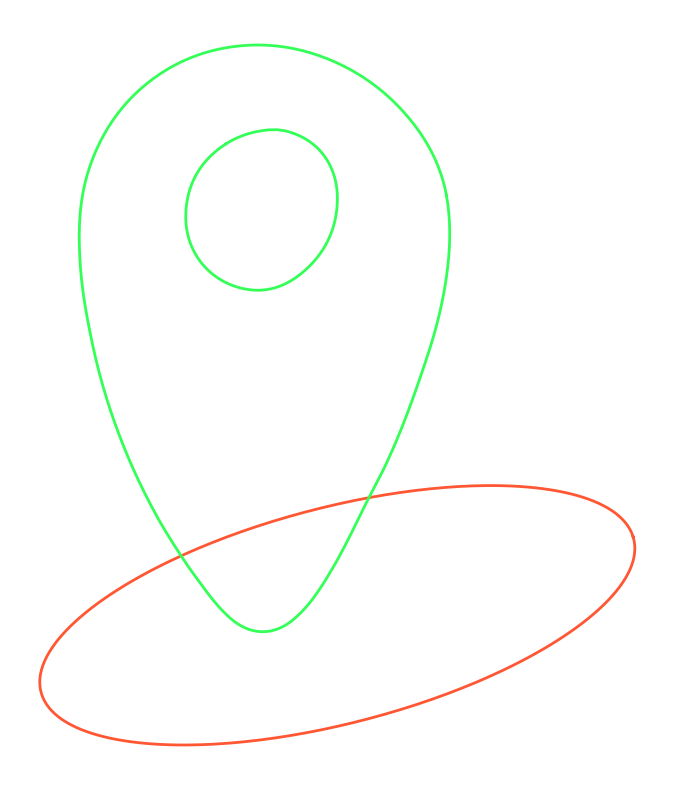

In [68]:
def apply_occlusion(paths, occlusion_rect):
    """
    Apply occlusion to the paths.

    :param paths: List of paths to be occluded.
    :param occlusion_rect: Tuple defining the occlusion rectangle (xmin, xmax, ymin, ymax).
    :return: List of occluded paths and list of occluded segments.
    """
    occluded_paths = []
    occluded_segments = []
    xmin, xmax, ymin, ymax = occlusion_rect

    for path in paths:
        # Create a mask for the occlusion
        mask = (path[:, 0] < xmin) | (path[:, 0] > xmax) | (path[:, 1] < ymin) | (path[:, 1] > ymax)
        occluded_path = path[mask]
        occluded_paths.append(occluded_path)

        # Store the occluded segments
        occluded_segment = path[~mask]
        if len(occluded_segment) > 0:
            occluded_segments.append(occluded_segment)

    return occluded_paths, occluded_segments

def plot_occluded_paths(occluded_paths, occluded_segments, occlusion_rect):
    """
    Plot the occluded paths with the occlusion region.

    :param occluded_paths: List of occluded paths.
    :param occluded_segments: List of occluded segments.
    :param occlusion_rect: Tuple defining the occlusion rectangle (xmin, xmax, ymin, ymax).
    """
    plt.figure(figsize=(12, 8))

    # Plot the visible parts of the paths
    for path in occluded_paths:
        if len(path) > 0:
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2)

    # Plot the occluded segments
    for segment in occluded_segments:
        plt.plot(segment[:, 0], segment[:, 1], 'b-', linewidth=2, alpha=0.5)

    xmin, xmax, ymin, ymax = occlusion_rect
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color='red', alpha=0.3, label='Occlusion Region')
    plt.gca().add_patch(rect)

    plt.title('Curve with Occlusion (Full Path Visible)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_full_path_with_occlusion(paths, occlusion_rect):
    """
    Plot the full paths with the occlusion region overlay.

    :param paths: List of paths to be plotted.
    :param occlusion_rect: Tuple defining the occlusion rectangle (xmin, xmax, ymin, ymax).
    """
    plt.figure(figsize=(12, 8))

    # Plot all paths in full
    for path in paths:
        plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2)

    xmin, xmax, ymin, ymax = occlusion_rect
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         color='red', alpha=0.3, label='Occlusion Region')
    plt.gca().add_patch(rect)

    plt.title('Curve with Occlusion (Full Path Visible)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()

def complete_occluded_path(path, occlusion_rect):
    """
    Complete the path through the occluded region using interpolation.

    :param path: NumPy array representing the path.
    :param occlusion_rect: Tuple defining the occlusion rectangle (xmin, xmax, ymin, ymax).
    :return: Completed path.
    """
    xmin, xmax, ymin, ymax = occlusion_rect

    # Find points just before and after the occlusion
    before_occlusion = path[path[:, 0] < xmin]
    after_occlusion = path[path[:, 0] > xmax]

    if len(before_occlusion) == 0 or len(after_occlusion) == 0:
        return path  # Return original path if we can't interpolate

    # Get the last point before occlusion and first point after occlusion
    p1 = before_occlusion[-1]
    p2 = after_occlusion[0]

    # Create a simple linear interpolation between these points
    t = np.linspace(0, 1, 100)
    interpolated_segment = np.column_stack([
        np.interp(t, [0, 1], [p1[0], p2[0]]),
        np.interp(t, [0, 1], [p1[1], p2[1]])
    ])

    # Combine the segments
    completed_path = np.vstack([before_occlusion, interpolated_segment, after_occlusion])

    return completed_path

def plot_completed_paths(paths, occlusion_rect):
    """
    Plot the completed paths with the occlusion region.

    :param paths: List of paths to be plotted.
    :param occlusion_rect: Tuple defining the occlusion rectangle (xmin, xmax, ymin, ymax).
    """
    plt.figure(figsize=(12, 8))

    for path in paths:
        completed_path = complete_occluded_path(path, occlusion_rect)
        plt.plot(completed_path[:, 0], completed_path[:, 1], 'b-', linewidth=2)

    xmin, xmax, ymin, ymax = occlusion_rect
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         color='red', alpha=0.3, label='Occlusion Region')
    plt.gca().add_patch(rect)

    plt.title('Curve with Occlusion (Paths Completed)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()
    plt.show()

def complete_path(path):
    """
    Complete the path using spline interpolation.

    :param path: NumPy array representing the path.
    :return: Completed path.
    """
    # Create a parameterization of the path
    t = np.arange(len(path))

    # Create interpolation functions for x and y coordinates
    fx = interp1d(t, path[:, 0], kind='cubic', fill_value='extrapolate')
    fy = interp1d(t, path[:, 1], kind='cubic', fill_value='extrapolate')

    # Create a finer parameterization
    t_fine = np.linspace(0, len(path) - 1, num=1000)

    # Interpolate to get the completed path
    completed_path = np.column_stack([fx(t_fine), fy(t_fine)])

    return completed_path

# Define the occlusion rectangle (xmin, xmax, ymin, ymax)
occlusion_rect = (0.4, 0.6, 0.4, 0.6)

# Plot the completed paths
occluded_paths, occluded_segments = apply_occlusion(smoothened_paths, occlusion_rect)

# Plot the occluded paths
plot(path_YXs, output_jpg_path)